In [1]:
import random
import heapq
import time
from prettytable import PrettyTable
import unittest
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress, t
from sortedcontainers import SortedList
import pandas as pd
import seaborn as sns

In [2]:
class NodeInfo:
    def __init__(self, sat, deg, vertex):
        self.sat = sat
        self.deg = deg
        self.vertex = vertex

    def __lt__(self, other):
        return (-self.sat, -self.deg, self.vertex) < (-other.sat, -other.deg, other.vertex)
        
class DSaturNode:
    def __init__(self, vertex, degree):
        self.vertex = vertex
        self.degree = degree
        self.saturation = 0

    def __lt__(self, other):
        return (self.saturation, -self.degree, self.vertex) < (other.saturation, -other.degree, other.vertex)

    def update(self, new_saturation, new_degree):
        self.saturation = new_saturation
        self.degree = new_degree

class Graph:
    def __init__(self, numNodes):
        self.n = numNodes
        self.adj = [[] for _ in range(numNodes)]
        self.color = [-1] * numNodes
        self.nodes = [DSaturNode(i, 0) for i in range(numNodes)]  # Initialize nodes

    def addEdge(self, u, v):
        self.adj[u].append(v)
        self.adj[v].append(u)
        self.nodes[u].degree += 1
        self.nodes[v].degree += 1

    def DSatur(self):
        sorted_nodes = SortedList(self.nodes, key=lambda node: (node.saturation, -node.degree))
        while sorted_nodes:
            node = sorted_nodes.pop(-1)
            u = node.vertex
            used_colors = {self.color[v] for v in self.adj[u] if self.color[v] != -1}
            self.color[u] = min(set(range(len(self.adj[u]) + 1)) - used_colors)
            
            for v in self.adj[u]:
                if self.color[v] == -1:
                    v_node = self.nodes[v]
                    sorted_nodes.discard(v_node)
                    new_saturation = len({self.color[n] for n in self.adj[v] if self.color[n] != -1})
                    v_node.update(new_saturation, len(self.adj[v]))
                    sorted_nodes.add(v_node)

    @classmethod
    def GenerateRandomGraph(cls, numVertices, numEdges, seed=None):
        if seed is not None:
            random.seed(seed)
        graph = cls(numVertices)
        possibleEdges = [(i, j) for i in range(numVertices) for j in range(i + 1, numVertices)]
        if numEdges > len(possibleEdges):
            raise ValueError("Number of edges requested exceeds the maximum possible for a simple graph with given vertices")
        random.shuffle(possibleEdges)
        for _ in range(numEdges):
            u, v = possibleEdges.pop()
            graph.addEdge(u, v)
        return graph

    def is_safe(self, v, c):
        for neighbor in self.adj[v]:
            if c == self.color[neighbor]:
                return False
        return True

    def graph_coloring_util(self, m, v):
        if v == self.n:
            return True
        for c in range(1, m + 1):
            if self.is_safe(v, c):
                self.color[v] = c
                if self.graph_coloring_util(m, v + 1):
                    return True
                self.color[v] = -1  # Backtrack
        return False

    def graph_coloring_backtracking(self):
        for m in range(1, self.n + 1):  # Try increasing number of colors
            self.color = [-1] * self.n  # Reset colors before trying
            if self.graph_coloring_util(m, 0):
                return m  # Minimum colors needed
        return self.n  # If not colorable, return total number of vertices
                    
    def verify_coloring(self):
        for u in range(self.n):
            for v in self.adj[u]:
                if u < v and self.color[u] == self.color[v]:
                    return False
        return True



In [3]:
# Number of trials for averaging the time taken
num_trials = 5

# Prepare to test various graph sizes with the backtracking method
# vertex_sizes = [3,4, 5, 6, 7, 8, 9,10,11,12,13,14,15,20,25,50,75,100,150,200]
# edge_sizes =   [3,6,10,15,21,28,18,10,15,24,30,50,70,100,120,250,500,1000,1500,5000]
vertex_sizes = [3,4, 5, 6, 7, 8, 9,10]
edge_sizes =   [3,6,10,15,21,28,18,10]

In [4]:


# Backtracking Results
results_table_backtrack = PrettyTable()
results_table_backtrack.field_names = ["Vertex Size", "Number of Edges", "Average Time Taken (s)", "Successful"]

for size, num_edges in zip(vertex_sizes, edge_sizes):
    total_duration = 0
    successful = False
    colors_used = 0
    for _ in range(num_trials):
        G = Graph.GenerateRandomGraph(size, num_edges)
        start_time = time.time()
        colors_used = G.graph_coloring_backtracking()
        successful = G.verify_coloring()
        end_time = time.time()
        total_duration += end_time - start_time
    avg_duration = total_duration / num_trials
    results_table_backtrack.add_row([size, num_edges, f"{avg_duration:.6f}", successful])

print("Backtracking Results:")
print(results_table_backtrack)

Backtracking Results:
+-------------+-----------------+------------------------+------------+
| Vertex Size | Number of Edges | Average Time Taken (s) | Successful |
+-------------+-----------------+------------------------+------------+
|      3      |        3        |        0.000007        |    True    |
|      4      |        6        |        0.000017        |    True    |
|      5      |        10       |        0.000072        |    True    |
|      6      |        15       |        0.000408        |    True    |
|      7      |        21       |        0.003147        |    True    |
|      8      |        28       |        0.023735        |    True    |
|      9      |        18       |        0.000072        |    True    |
|      10     |        10       |        0.000023        |    True    |
+-------------+-----------------+------------------------+------------+


In [5]:
# DSatur Results
results_table_dsatur = PrettyTable()
results_table_dsatur.field_names = ["Vertex Size", "Number of Edges", "Average Time Taken (s)", "Successful", "Colors Used"]

for size, num_edges in zip(vertex_sizes, edge_sizes):
    total_duration = 0
    successful = 0  # To count how many trials were successful
    colors_used = 0
    for _ in range(num_trials):
        G = Graph.GenerateRandomGraph(size, num_edges)
        start_time = time.time()
        G.DSatur()  # Assuming this sets the colors on the graph
        success = G.verify_coloring()
        end_time = time.time()
        total_duration += end_time - start_time
        if success:
            successful += 1
            colors_used = max(G.color) + 1  # Assuming colors are 0-indexed

    avg_duration = total_duration / num_trials
    success_rate = successful / num_trials
    results_table_dsatur.add_row([size, num_edges, f"{avg_duration:.6f}", f"{success_rate:.2%}", colors_used])
print("DSatur Results:")
print(results_table_dsatur)

DSatur Results:
+-------------+-----------------+------------------------+------------+-------------+
| Vertex Size | Number of Edges | Average Time Taken (s) | Successful | Colors Used |
+-------------+-----------------+------------------------+------------+-------------+
|      3      |        3        |        0.000029        |  100.00%   |      3      |
|      4      |        6        |        0.000021        |  100.00%   |      4      |
|      5      |        10       |        0.000031        |  100.00%   |      5      |
|      6      |        15       |        0.000042        |  100.00%   |      6      |
|      7      |        21       |        0.000059        |  100.00%   |      7      |
|      8      |        28       |        0.000078        |  100.00%   |      8      |
|      9      |        18       |        0.000056        |  100.00%   |      3      |
|      10     |        10       |        0.000040        |  100.00%   |      3      |
+-------------+-----------------+-----

In [6]:
# Test class for the Graph and DSatur algorithm
class TestDSaturAlgorithm(unittest.TestCase):

    def no_vertext():
        g = Graph (0)
        g.Dsatur()
        self.assertEqual(len(g.color), 0)

    def test_single_vertex(self):
        g = Graph(1)
        g.DSatur()
        self.assertEqual(g.color[0], 0)  # Single vertex should be colored with the first color

    def test_two_connected_vertices(self):
        g = Graph(2)
        g.addEdge(0, 1)
        g.DSatur()
        self.assertNotEqual(g.color[0], g.color[1])  # Two connected vertices should have different colors

    def test_complete_graph(self):
        n = 4
        g = Graph(n)
        for i in range(n):
            for j in range(i + 1, n):
                g.addEdge(i, j)
        g.DSatur()
        self.assertEqual(len(set(g.color)), n)  # Each vertex in a complete graph should have a unique color

    def test_star_graph(self):
        # Testing a star graph structure
        n = 5
        g = Graph(n)
        for i in range(1, n):
            g.addEdge(0, i)
        g.DSatur()
        self.assertEqual(len(set(g.color[1:])), 1)  # Peripheral nodes can share the same color


    def test_linear_chain(self):
        # Testing a linear chain where colors should alternate minimally
        g = Graph(5)
        for i in range(4):
            g.addEdge(i, i + 1)
        g.DSatur()
        self.assertTrue(all(g.color[i] != g.color[i + 1] for i in range(4)))

    def test_graph_with_loops(self):
        # Ensure that self-loops do not affect coloring
        g = Graph(3)
        g.addEdge(0, 0)  # Self-loop
        g.addEdge(1, 2)
        g.DSatur()
        self.assertNotEqual(g.color[1], g.color[2])
        self.assertIn(0, g.adj[0])  # Self-loop check

    def test_complex_structures(self):
        # Test DSatur on complex graph structures like a wheel graph
        n = 6  # A wheel graph with 6 vertices
        g = Graph(n)
        for i in range(1, n):
            g.addEdge(0, i)  # Central hub to all other nodes
        for i in range(1, n - 1):
            g.addEdge(i, i + 1)  # Outer ring
        g.addEdge(1, n - 1)  # Closing the ring
        g.DSatur()
        self.assertTrue(g.verify_coloring())  # Verify the coloring is correct

def run_tests():
    suite = unittest.TestLoader().loadTestsFromTestCase(TestDSaturAlgorithm)
    # Using TextTestRunner to run the test suite and display results to the standard output.
    unittest.TextTestRunner(verbosity=2).run(suite)


In [7]:
   if __name__ == "__main__":
    run_tests()

test_complete_graph (__main__.TestDSaturAlgorithm.test_complete_graph) ... ok
test_complex_structures (__main__.TestDSaturAlgorithm.test_complex_structures) ... ok
test_graph_with_loops (__main__.TestDSaturAlgorithm.test_graph_with_loops) ... ok
test_linear_chain (__main__.TestDSaturAlgorithm.test_linear_chain) ... ok
test_single_vertex (__main__.TestDSaturAlgorithm.test_single_vertex) ... ok
test_star_graph (__main__.TestDSaturAlgorithm.test_star_graph) ... ok
test_two_connected_vertices (__main__.TestDSaturAlgorithm.test_two_connected_vertices) ... ok

----------------------------------------------------------------------
Ran 7 tests in 0.013s

OK


In [8]:
def run_black_box_tests():
    def test_empty_graph():
        graph = Graph(0)
        graph.DSatur()
        assert graph.verify_coloring(), "Test failed for empty graph"
        print("Test passed for empty graph")

    def test_single_vertex():
        graph = Graph(1)
        graph.DSatur()
        assert graph.verify_coloring(), "Test failed for single vertex graph"
        print("Test passed for single vertex graph")

    def test_two_connected_vertices():
        graph = Graph(2)
        graph.addEdge(0, 1)
        graph.DSatur()
        assert graph.verify_coloring(), "Test failed for two connected vertices graph"
        print("Test passed for two connected vertices graph")

    def test_triangle_graph():
        graph = Graph(3)
        graph.addEdge(0, 1)
        graph.addEdge(1, 2)
        graph.addEdge(0, 2)
        graph.DSatur()
        assert graph.verify_coloring(), "Test failed for triangle graph"
        print("Test passed for triangle graph")

    def test_complete_graph():
        graph = Graph(4)
        for i in range(4):
            for j in range(i + 1, 4):
                graph.addEdge(i, j)
        graph.DSatur()
        assert graph.verify_coloring(), "Test failed for complete graph"
        print("Test passed for complete graph")

    def test_bipartite_graph():
        graph = Graph(6)
        graph.addEdge(0, 3)
        graph.addEdge(0, 4)
        graph.addEdge(0, 5)
        graph.addEdge(1, 3)
        graph.addEdge(1, 4)
        graph.addEdge(1, 5)
        graph.DSatur()
        assert graph.verify_coloring(), "Test failed for bipartite graph"
        print("Test passed for bipartite graph")

    def test_line_graph():
        graph = Graph(4)
        graph.addEdge(0, 1)
        graph.addEdge(1, 2)
        graph.addEdge(2, 3)
        graph.DSatur()
        assert graph.verify_coloring(), "Test failed for line graph"
        print("Test passed for line graph")

    def test_cycle_graph():
        graph = Graph(4)
        graph.addEdge(0, 1)
        graph.addEdge(1, 2)
        graph.addEdge(2, 3)
        graph.addEdge(3, 0)
        graph.DSatur()
        assert graph.verify_coloring(), "Test failed for cycle graph"
        print("Test passed for cycle graph")

    def test_sparse_graph():
        graph = Graph.GenerateRandomGraph(100, 10)
        graph.DSatur()
        assert graph.verify_coloring(), "Test failed for sparse graph"
        print("Test passed for sparse graph")

    def test_dense_graph():
        graph = Graph.GenerateRandomGraph(50, 1225)
        graph.DSatur()
        assert graph.verify_coloring(), "Test failed for dense graph"
        print("Test passed for dense graph")

    test_empty_graph()
    test_single_vertex()
    test_two_connected_vertices()
    test_triangle_graph()
    test_complete_graph()
    test_bipartite_graph() 
    test_line_graph()
    test_cycle_graph()
    test_sparse_graph()
    test_dense_graph()

run_black_box_tests()

Test passed for empty graph
Test passed for single vertex graph
Test passed for two connected vertices graph
Test passed for triangle graph
Test passed for complete graph
Test passed for bipartite graph
Test passed for line graph
Test passed for cycle graph
Test passed for sparse graph
Test passed for dense graph


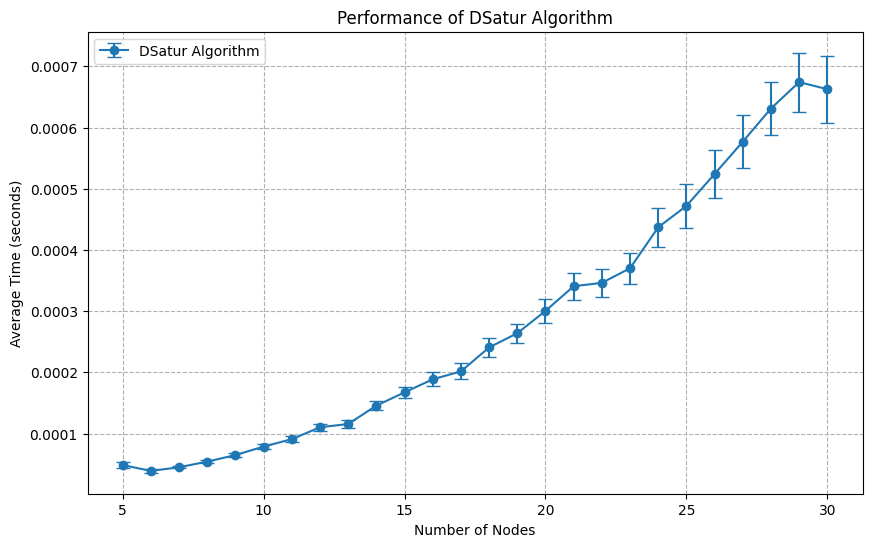

Equation of the fitted line: log10(T(n)) = 1.75 * log10(n) + -5.80
Practical complexity: O(n^1.75)


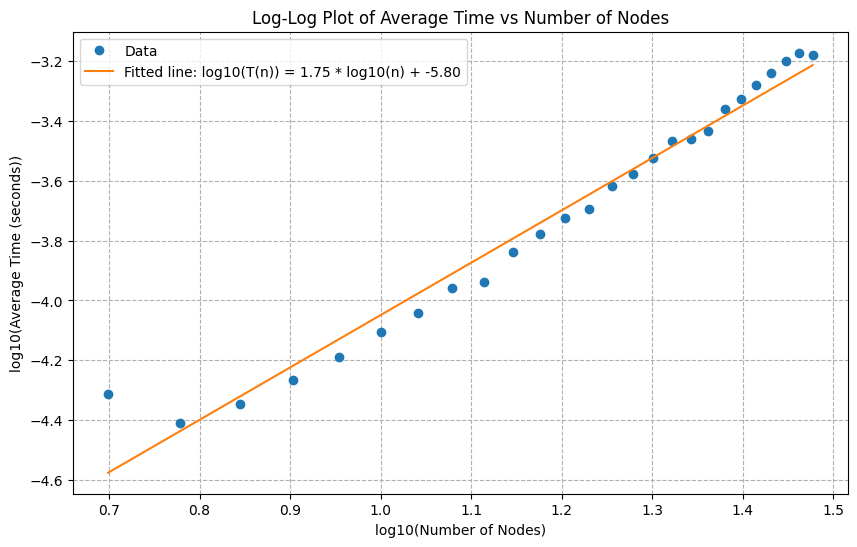

In [15]:
def measure_time(numNodes, numEdges):
    graph = Graph.GenerateRandomGraph(numNodes, numEdges)
    start_time = time.time()
    graph.DSatur()
    end_time = time.time()
    return end_time - start_time

def main():
    input_sizes = range(5, 31)  # Vertex count from 5 to 30
    numEdges = lambda n: random.randint(n, n*(n-1)//2)  # Random edge count between n and maximum possible edges
    k = 200  # Number of random graphs to generate for each input size, typically a robust choice for statistical analysis

    results = []
    conf_intervals = []

    for n in input_sizes:
        times = []
        for _ in range(k):
            e = numEdges(n)
            time_taken = measure_time(n, e)
            times.append(time_taken)
        avg_time = np.mean(times)
        std_dev = np.std(times, ddof=1)
        conf_interval = t.ppf(0.975, k-1) * std_dev / np.sqrt(k)  # 95% confidence interval
        results.append(avg_time)
        conf_intervals.append(conf_interval)

    # Plotting the results with confidence intervals
    plt.figure(figsize=(10, 6))
    plt.errorbar(input_sizes, results, yerr=conf_intervals, fmt='-o', capsize=5, label='DSatur Algorithm')

    plt.xlabel('Number of Nodes')
    plt.ylabel('Average Time (seconds)')
    plt.title('Performance of DSatur Algorithm')
    plt.legend()
    plt.grid(True, which="both", ls="--")
    plt.show()

    # Log-log transformation
    log_input_sizes = np.log10(input_sizes)
    log_results = np.log10(results)

    # Fit a linear model to the log-log data
    coefficients = np.polyfit(log_input_sizes, log_results, 1)
    slope, intercept = coefficients

    # Print the equation of the fitted line and complexity
    print(f"Equation of the fitted line: log10(T(n)) = {slope:.2f} * log10(n) + {intercept:.2f}")
    print(f"Practical complexity: O(n^{slope:.2f})")

    # Plot the log-log data and the fitted line
    plt.figure(figsize=(10, 6))
    plt.plot(log_input_sizes, log_results, 'o', label='Data')
    plt.plot(log_input_sizes, np.polyval(coefficients, log_input_sizes), '-', label=f'Fitted line: log10(T(n)) = {slope:.2f} * log10(n) + {intercept:.2f}')
    plt.xlabel('log10(Number of Nodes)')
    plt.ylabel('log10(Average Time (seconds))')
    plt.title('Log-Log Plot of Average Time vs Number of Nodes')
    plt.legend()
    plt.grid(True, which="both", ls="--")
    plt.show()

if __name__ == "__main__":
    main()

,Number of Nodes,Number of Edges,DSatur Algorithm,Backtracking Algorithm,Ratio of Heuristic/Exact
0,10,20,4,4,1.00
1,12,25,3,3,1.00
2,14,36,5,4,1.25
3,16,44,5,5,1.00
4,18,54,5,4,1.25
5,20,60,5,4,1.25
6,22,65,5,4,1.25
7,25,75,5,4,1.25
8,28,90,5,4,1.25
9,30,100,6,4,1.50


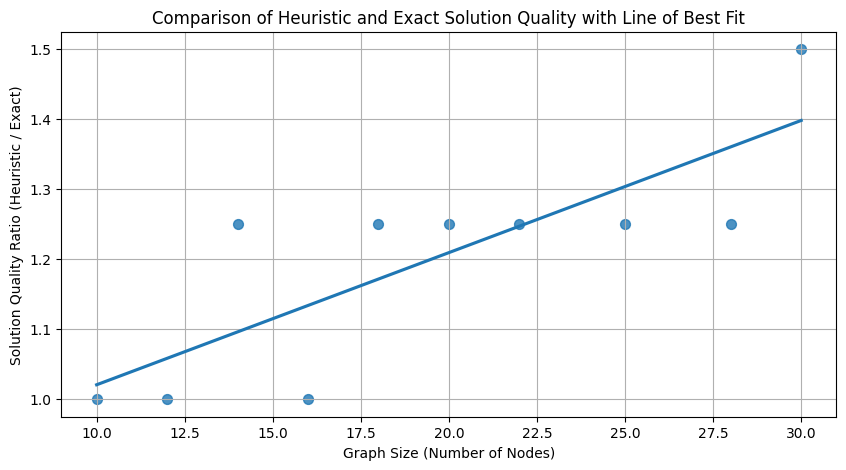

In [10]:
def compare_algorithms(graph_sizes, num_edges):
    dsatur_results = []
    backtracking_results = []

    for i, size in enumerate(graph_sizes):
        graph = Graph.GenerateRandomGraph(size, num_edges[i],42)
        
        # DSatur Algorithm
        graph.DSatur()
        dsatur_color_count = max(graph.color) + 1
        dsatur_results.append(dsatur_color_count)
        
        # Backtracking Algorithm
        graph.color = [-1] * graph.n  # Reset colors before running backtracking
        backtracking_color_count = graph.graph_coloring_backtracking()
        backtracking_results.append(backtracking_color_count)
    
    return dsatur_results, backtracking_results

def plot_results_with_confidence_interval(graph_sizes, ratios):
    plt.figure(figsize=(10, 5))
    sns.regplot(x=graph_sizes, y=ratios, scatter_kws={'s':50}, ci=None)
    plt.xlabel('Graph Size (Number of Nodes)')
    plt.ylabel('Solution Quality Ratio (Heuristic / Exact)')
    plt.title('Comparison of Heuristic and Exact Solution Quality with Line of Best Fit')
    plt.grid(True)
    plt.show()

def display_results_table(graph_sizes, dsatur_results, backtracking_results, num_edges):
    ratios = [d/b for d, b in zip(dsatur_results, backtracking_results)]
    data = {
        "Number of Nodes": graph_sizes,
        "Number of Edges": num_edges,
        "DSatur Algorithm": dsatur_results,
        "Backtracking Algorithm": backtracking_results,
        "Ratio of Heuristic/Exact": ratios
    }
    df = pd.DataFrame(data)
    display(df)
    plot_results_with_confidence_interval(graph_sizes, ratios)

# Example usage
graph_sizes = [10,12,14,16,18,20,22,25,28,30]
num_edges = [  20,25,36,44,54,60,65,75,90,100]
dsatur_results, backtracking_results = compare_algorithms(graph_sizes, num_edges)
display_results_table(graph_sizes, dsatur_results, backtracking_results, num_edges)

,Number of Nodes,Number of Edges,DSatur Algorithm,Backtracking Algorithm,Ratio of Heuristic/Exact
0,10,1,2,2,1.0
1,20,1,2,2,1.0
2,30,1,2,2,1.0
3,40,1,2,2,1.0
4,50,1,2,2,1.0
5,60,1,2,2,1.0
6,70,1,2,2,1.0
7,80,1,2,2,1.0
8,90,1,2,2,1.0
9,100,1,2,2,1.0


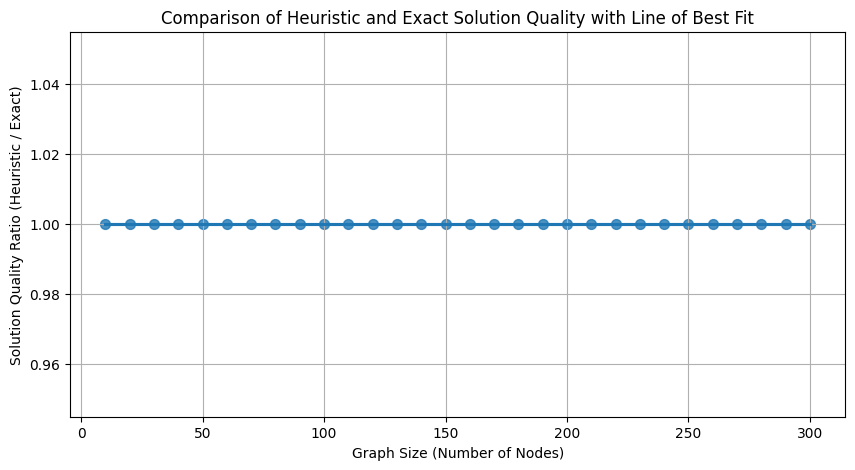

In [11]:
# 1 Edge Examples 
graph_sizes = [10,20,30,40,50,60,70,80,90,100,110,120,130,140,150,160,170,180,190,200,210,220,230,240,250,260,270,280,290,300]
num_edges = [1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1]
dsatur_results, backtracking_results = compare_algorithms(graph_sizes, num_edges)
display_results_table(graph_sizes, dsatur_results, backtracking_results, num_edges)

,Number of Nodes,Number of Edges,DSatur Algorithm,Backtracking Algorithm,Ratio of Heuristic/Exact
0,3,3,3,3,1.0
1,4,6,4,4,1.0
2,5,10,5,5,1.0
3,6,15,6,6,1.0
4,7,21,7,7,1.0
5,8,28,8,8,1.0
6,9,36,9,9,1.0
7,10,45,10,10,1.0


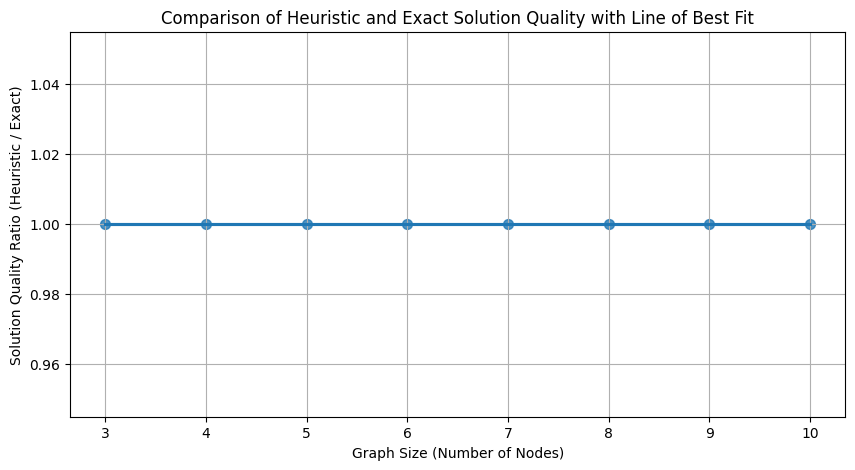

In [12]:
# Max Edge Examples 
graph_sizes = [3,4,5,6,7,8,9,10]
num_edges = [3,6,10,15,21,28,36,45]
dsatur_results, backtracking_results = compare_algorithms(graph_sizes, num_edges)
display_results_table(graph_sizes, dsatur_results, backtracking_results, num_edges)